## Potatoe Disease Classifier Algorithm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers


In [19]:
#data input pipeline
channels=3
img_size=256
batch_size=32
dt=tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    shuffle= True,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=(batch_size)
)

Found 2152 files belonging to 3 classes.


In [3]:
class_names= dt.class_names
print(class_names)
print(len(dt))


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
68


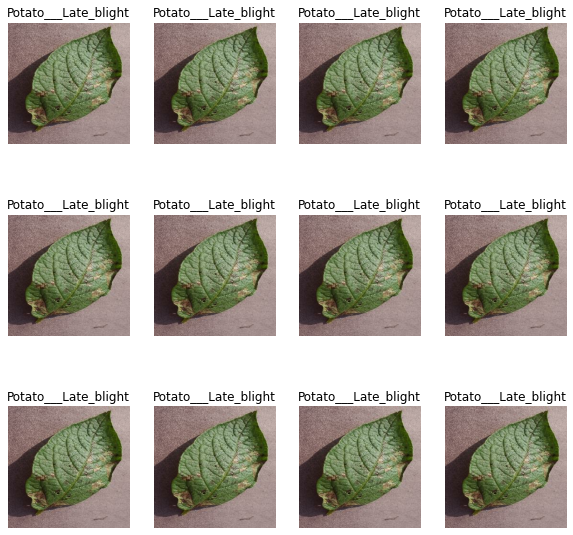

In [4]:
#displaying sample imgs
plt.figure(figsize=(10,10))
for img_batch, label_batch in dt.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(img_batch[0].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[0]])

In [5]:
for img_batch,label_batch in dt.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 2 0 0 0 0 1 1 0]


In [9]:
#function to partition the dataset into train, val and test dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dt)

In [11]:
#printing len of each dataset

print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


## Building Model

In [14]:
#The neural network expect images of dimensions 256 by 256
#Any image to be fed into the network must be of this size
#creating the resize and rescale layer

resize_rescale= tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(img_size, img_size),
        layers.experimental.preprocessing.Rescaling(1.0/255),
    ]
)

In [18]:
#Data augmentation
#Data augmentation is required in order to increase our dataset and boost model accuracy

data_aug=tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2),
    ]
)

#applying data augmentation to trained dataset

train_ds=train_ds.map(
    lambda x,y:(data_aug(x,training=True),y)
).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Model Architecture

In [24]:
input_shape=(batch_size, img_size,img_size,channels)
num_classes=3
model= models.Sequential(
[
    resize_rescale,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
  
]
)

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (32, 30, 30, 64)         

In [37]:
#Compiling the model
#Use SGD optimiser,sparsecategoricalcrossentropyloss for losses, and accuracy as a metric

model.compile(
    optimizer='sgd',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [38]:
hist=model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=3,
)

Epoch 1/3
54/54 [==============================] - 91s 2s/step - loss: 0.6714 - accuracy: 0.7295 - val_loss: 0.4237 - val_accuracy: 0.8438
Epoch 2/3
54/54 [==============================] - 92s 2s/step - loss: 0.4471 - accuracy: 0.8333 - val_loss: 0.4623 - val_accuracy: 0.8438
Epoch 3/3
54/54 [==============================] - 90s 2s/step - loss: 0.4172 - accuracy: 0.8433 - val_loss: 0.3781 - val_accuracy: 0.8802


In [39]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 3s 316ms/step - loss: 0.4521 - accuracy: 0.8320


In [40]:
#plotting the accuracy and loss curves

acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']

loss=hist.history['loss']
val_loss=hist.history['val_loss']


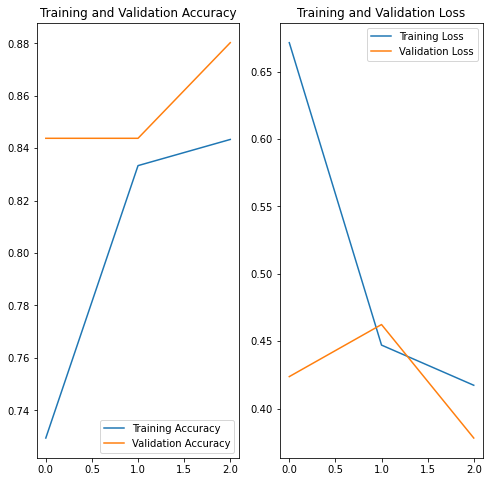

In [43]:
epochs=3
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc,label='Training Accuracy')

plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs),loss, label='Training Loss')
plt.plot(range(epochs),val_loss, label='Validation Loss')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Running prediction on first sample image
Actual label: Potato___Late_blight
Predicted Label:  Potato___Late_blight


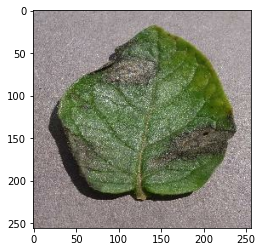

In [49]:
#runing prediction on first sample image

import numpy as np

for image_batch,labels_batch in test_ds.take(1):
    image=image_batch[0].numpy().astype('uint8')
    label=labels_batch[0].numpy()
    
    print('Running prediction on first sample image')
    plt.imshow(image)
    print("Actual label:",class_names[label])
    
    batch_pred=model.predict(image_batch)
    
    print("Predicted Label: ",class_names[np.argmax(batch_pred[0])])

In [50]:
#Building function for model inference

def predict(model, img):
    img_arr=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_arr=tf.expand_dims(img_arr,0)
    
    predictions= model.predict(img_arr)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence= round(1000*(np.max(predictions[0])),2)
    
    return predicted_class, confidence
    

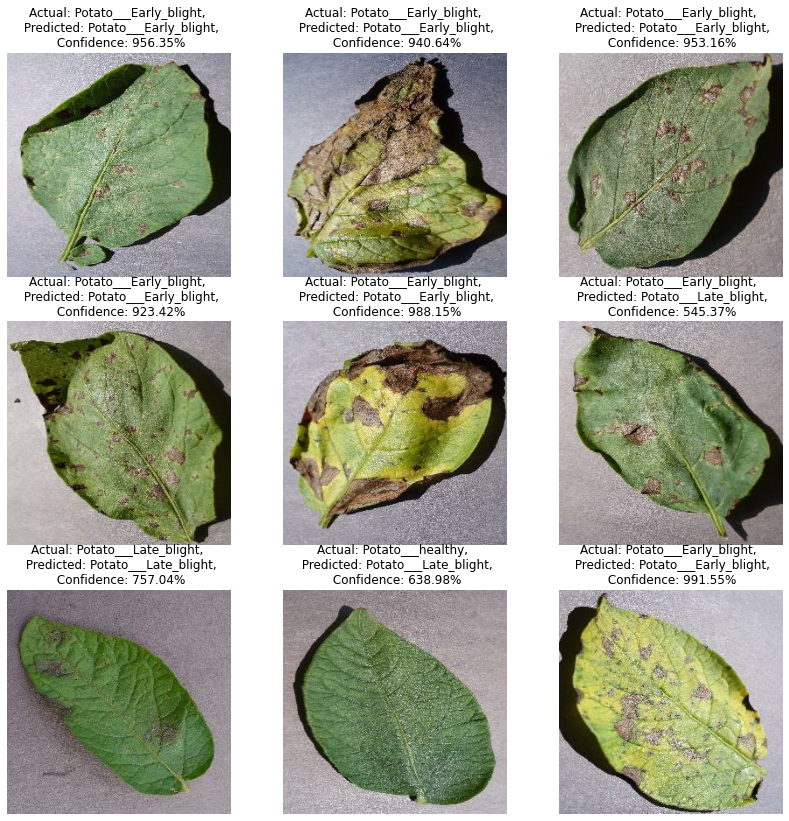

In [68]:
#run the func on certain images

plt.figure(figsize=(14,14))
for images, labels, in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence= predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class},\n Confidence: {confidence}%")
        
        plt.axis('off')

Saving the model

In [66]:
#import os
#path=os.getcwd()
#model_version=max([int(i) for i in os.listdir(path)+[0]])+1
model.save("model/pdd_model")

INFO:tensorflow:Assets written to: model/pdd_model\assets
